In [1]:
import os
from collections import defaultdict
import pickle

import numpy as np
import matplotlib.pyplot as plt

from utils.parse_logs import parse_metrics

In [2]:
DATASET = 'Cora'
METRIC = 'F1 Score'
PAR_DIR = f'./results/drop-edge/short-range/{DATASET}'
GNNs = ('GCN',)
DEPTHS = range(2, 9)
Ps = np.round(np.arange(0.1, 1, 0.1), decimals=1)

In [3]:
train_accs = defaultdict(list)
es_test_accs = defaultdict(list)

for gnn in GNNs:
    for depth in DEPTHS:
        for p in Ps:
            exp_dir = f'{PAR_DIR}/{gnn}/L={depth}/P={p}'
            for sample_dir in os.listdir(exp_dir):
                train, val, test = parse_metrics(f'{exp_dir}/{sample_dir}/logs')
                if max(train[METRIC]) < 0.2:
                    continue
                train_accs[(gnn, depth, p)].append(max(train[METRIC]))
                es_test_accs[(gnn, depth, p)].append(test[METRIC][np.argmax(val[METRIC])])

train_accs = {exp: (np.mean(samples), np.std(samples)) for exp, samples in train_accs.items()}
es_test_accs = {exp: (np.mean(samples), np.std(samples)) for exp, samples in es_test_accs.items()}

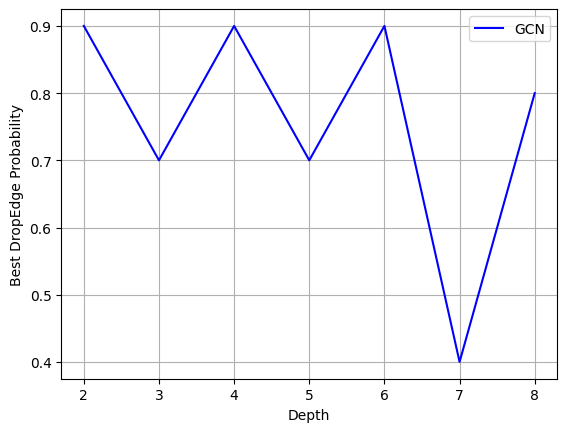

In [4]:
for gnn, color in zip(GNNs, ('blue', 'green')):
    best_probs = list()
    for depth in DEPTHS:
        best_probs.append(Ps[np.argmax([es_test_accs[(gnn, depth, p)][0] for p in Ps])])
    plt.plot(DEPTHS, best_probs, color=color, label=gnn)

plt.xlabel('Depth')
plt.ylabel('Best DropEdge Probability')
plt.legend()
plt.grid()
plt.show()

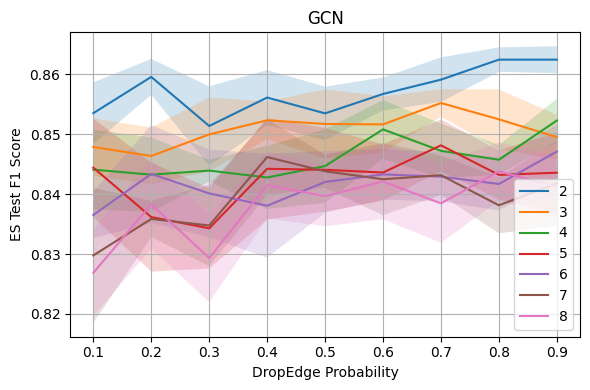

In [5]:
fig, axs = plt.subplots(1, len(GNNs), figsize=(6*len(GNNs), 4))
if not hasattr(axs, '__len__'): axs = (axs,)

for gnn, ax in zip(GNNs, axs):
    for depth in DEPTHS:
        lower = ([es_test_accs[(gnn, depth, drop_p)][0]-es_test_accs[(gnn, depth, drop_p)][1] for drop_p in Ps])
        mean = ([es_test_accs[(gnn, depth, drop_p)][0] for drop_p in Ps])
        upper = ([es_test_accs[(gnn, depth, drop_p)][0]+es_test_accs[(gnn, depth, drop_p)][1] for drop_p in Ps])
        ax.plot(Ps, mean, label=depth)
        ax.fill_between(Ps, lower, upper, alpha=0.2)
    ax.set_xlabel('DropEdge Probability')
    ax.set_ylabel(f'ES Test {METRIC}')
    ax.set_title(gnn)
    ax.legend()
    ax.grid()

fig.tight_layout()
plt.show()

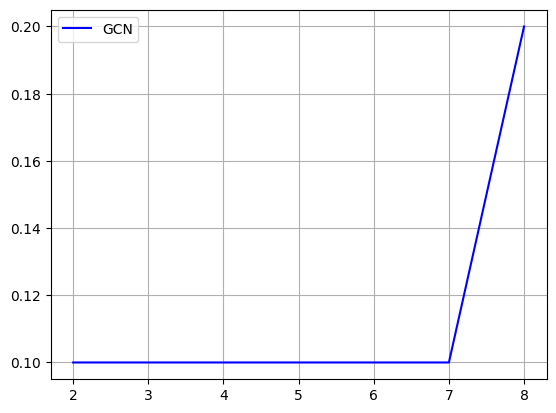

In [6]:
for gnn, color in zip(GNNs, ('blue', 'green')):
    best_probs = list()
    for depth in DEPTHS:
        best_probs.append(Ps[np.argmax([train_accs[(gnn, depth, drop_p)][0] for drop_p in Ps])])
    plt.plot(DEPTHS, best_probs, color=color, label=gnn)

plt.legend()
plt.grid()
plt.show()

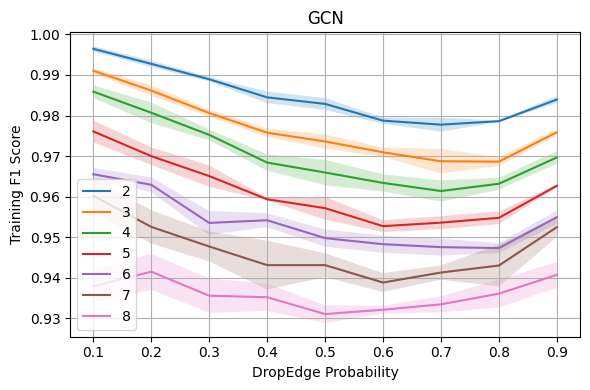

In [7]:
fig, axs = plt.subplots(1, len(GNNs), figsize=(6*len(GNNs), 4))
if not hasattr(axs, '__len__'): axs = (axs,)

for gnn, ax in zip(GNNs, axs):
    for depth in DEPTHS:
        lower = ([train_accs[(gnn, depth, drop_p)][0]-train_accs[(gnn, depth, drop_p)][1] for drop_p in Ps])
        mean = ([train_accs[(gnn, depth, drop_p)][0] for drop_p in Ps])
        upper = ([train_accs[(gnn, depth, drop_p)][0]+train_accs[(gnn, depth, drop_p)][1] for drop_p in Ps])
        ax.plot(Ps, mean, label=depth)
        ax.fill_between(Ps, lower, upper, alpha=0.2)
    ax.set_xlabel('DropEdge Probability')
    ax.set_ylabel(f'Training {METRIC}')
    ax.set_title(gnn)
    # ax.set_ylim((0.92, 1.0))
    ax.legend()
    ax.grid()

fig.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './results/drop-edge/short-range/Cora/GAT/config.pkl'

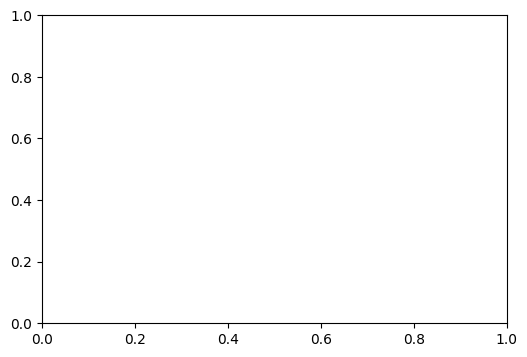

In [8]:
fig, axs = plt.subplots(1, len(GNNs), figsize=(6*len(GNNs), 4))
if not hasattr(axs, '__len__'): axs = (axs,)

for gnn, ax in zip(GNNs, axs):
    plotted = set()
    for exp_dir in os.listdir(PAR_DIR):
        with open(f'{PAR_DIR}/{exp_dir}/config.pkl', 'rb') as f:
            config = pickle.load(f)
        depth = len(config.gnn_layer_sizes)
        if config.dataset == DATASET and config.gnn in GNNs and config.dropout == 'DropEdge' and config.drop_p == 0.9 and depth not in plotted:
            train, val, test = parse_metrics(f'{PAR_DIR}/{exp_dir}/logs')
            ax.plot(train['Epoch'], train[METRIC], label=depth)
            plotted.add(depth)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'Training {METRIC}')
    ax.set_title(gnn)
    ax.grid()
    ax.legend()

fig.tight_layout()
plt.show()